In [45]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, get_icrs_coordinates
from astropy.io import fits
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
import os
from astroquery.skyview import SkyView

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline

In [26]:
# Read in continuum data

#cont_data = fits.open('/Users/denes/Research/high_lat_HI/ASKAP_data/Hydra_continuum/image.i.SB10612_v2.fits')  # this is an individual file
cont_data = fits.open('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits')  # This is the mosaic file
d = cont_data[0].data
h = cont_data[0].header
#d = d[0,0,:,:]
print(d.shape)

(15851, 24850)


In [ ]:
plt.imshow(d)

In [27]:
# make a list of the HI mom 0 maps

#files = os.listdir('/Users/denes/Research/WALLABY/Hydra_dr1/WALLABY_PS_Hya_DR1_source_products/') 
files = os.listdir('/Users/denes/Research/WALLABY/Hydra_dr2/Hydra_dr2/WALLABY_PS_Hya_DR2_source_products/')

#print(files)
maps = []
for f in files:
    if '_mom0.fits' in f:
        maps.append(f)

print(maps[0])
print(len(maps))

WALLABY_J103701-284018_mom0.fits
273


In [ ]:
# make fancy HI overlay plots

for hi_map in maps:
    hi_data = fits.open('/Users/denes/Research/WALLABY/Hydra_dr2/Hydra_dr2/WALLABY_PS_Hya_DR2_source_products/{}'.format(hi_map))  # Open the FITS file for reading
    d_hi = hi_data[0].data
    h_hi = hi_data[0].header
    reprojected_cont, footprint = reproject_interp(cont_data, h_hi)


    # plot figure
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection=WCS(h))
    ax.set_title('{}'.format(hi_map[19:-5]), fontsize=20)

    # Display the moment map image
    im = ax.imshow(reprojected_cont, cmap='viridis', vmax=np.percentile(reprojected_cont, 99.8))
    ax.contour(d_hi, levels=2, colors='w', alpha=0.7)

    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    #ax.set_title('Hydra', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)
    cbar_hi = plt.colorbar(im, orientation='vertical', fraction=0.022, pad=0.12)
    #cbar_hi.set_label('NHI', size=18)

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    #plt.colorbar(im)
    fig.savefig('HI_continuum_overlays/{}_cont_map.png'.format(hi_map[8:-5]),dpi=200, bbox_inches='tight')

# Make an optical overlay

153.9493083333 -27.37438055556 1.0577055
10h15m47.834s -27d22m27.77s


[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x11b19f610>]]


Set OBSGEO-B to   -26.704100 from OBSGEO-[XYZ].
Set OBSGEO-H to      121.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecati

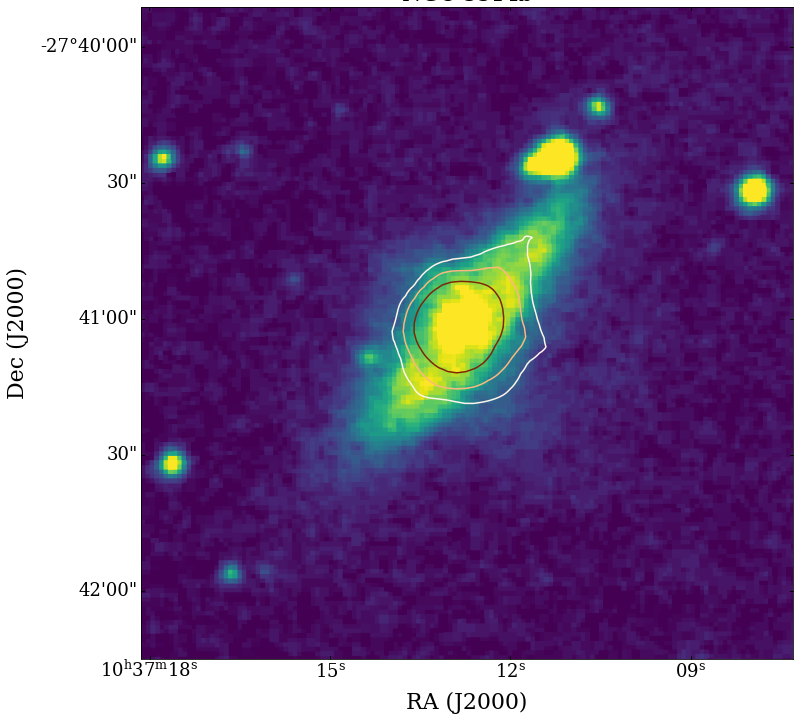

In [180]:
# read in HI data
# find optical image (DSS2 B)
# make the overlay
# note: sometimes there is no sufficently large (0.8 or 0.5 deg) optical image available, in this case the image is skipped

def make_overlay(HI_image, name, view):
    hdulist_hi = fits.open('{}'.format(HI_image))
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header
    d = np.nan_to_num(d)
    rms = np.sqrt(np.mean(np.square(d)))
    print(h['CRVAL1'],h['CRVAL2'], np.max(d))

    #get optical image
    c = SkyCoord(h['CRVAL1'], h['CRVAL2'], unit="deg")
    print(c.to_string('hmsdms'))
    path = SkyView.get_images(position=name, width=view*u.deg, height=view*u.deg, survey=['DSS2 Red'], pixels=[900,900])

    print(path)
    if len(path) !=0:

        hdulist_opt = path[0]
        d2 = hdulist_opt[0].data
        h2 = hdulist_opt[0].header

        #fig = plt.figure(figsize=(18, 12))
        #ax = fig.add_subplot(111)
        #im = ax.imshow(d2, cmap='Oranges')

        #reproject HI data

        hi_reprojected, footprint = reproject_interp(hdulist_hi, h2)
        rms = np.sqrt(np.mean(np.square(hi_reprojected)))

        #plot data together

        fig = plt.figure(figsize=(12, 12))
        ax1 = fig.add_subplot(111, projection=WCS(hdulist_opt[0].header))
        ax1.imshow(d2, cmap='viridis', vmin=np.percentile(d2,10), vmax=np.percentile(d2,99))
        ax1.contour(hi_reprojected, cmap='Oranges', levels=[rms, rms*2, rms*4])
        #ax1.contour(hi_reprojected, cmap='Oranges', levels=5)
        #levs = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])*10**22
        #ax1.contour(hi_reprojected, levels=0, cmap='Blues')
        #ax1.coords.grid(color='white')
        ax1.set_title(name, fontsize=22)
        ax1.tick_params(axis='both', which='major', labelsize=18)
        ax1.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
        ax1.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

        fig.savefig('{}_overlay_continuum_v2.png'.format(name), dpi=100)

#make_overlay('/Users/denes/Research/WALLABY/Hydra_dr1/WALLABY_PS_Hya_DR1_source_products/WALLABY_PS_Hya_DR1_J104016-274630_moment0.fits', 'NGC3336', 0.08)
#make_overlay('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'NGC3336', 0.08)
#make_overlay('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 31638', 0.08)
#make_overlay('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'NGC 3312', 0.2)
#make_overlay('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 753342', 0.05)
#make_overlay('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 31440', 0.05)
#make_overlay('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 29553', 0.05)
#make_overlay('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'NGC 3175', 0.5)
#make_overlay('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 30257', 0.05)
#make_overlay('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 30144', 0.05)
#make_overlay('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 762639', 0.05)
#make_overlay('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 29903', 0.04)
make_overlay('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'NGC 3314b', 0.04)


# Make HI overlays on optical images

153.949308333 -27.3743805556 2957.0762
153d56m57.51s -27d22m27.77s
[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x176fea210>]]


/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1161: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1161: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter

153.949308333 -27.3743805556 597.0187
153d56m57.51s -27d22m27.77s


[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x177fb4a10>]]


/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1161: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1161: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter

153.949308333 -27.3743805556 2010.0181
153d56m57.51s -27d22m27.77s
[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x17789ffd0>]]


/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1161: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1161: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter

153.949308333 -27.3743805556 4060.303
153d56m57.51s -27d22m27.77s
[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x177861610>]]


/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1161: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1161: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter

153.949308333 -27.3743805556 5138.512
153d56m57.51s -27d22m27.77s
[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x119a75950>]]


/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1161: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1161: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter

153.949308333 -27.3743805556 3994.9836
153d56m57.51s -27d22m27.77s
[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1772e4790>]]


/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1161: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1161: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter

153.949308333 -27.3743805556 1174.0653
153d56m57.51s -27d22m27.77s
[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x11930ce10>]]


KeyboardInterrupt: 

/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)


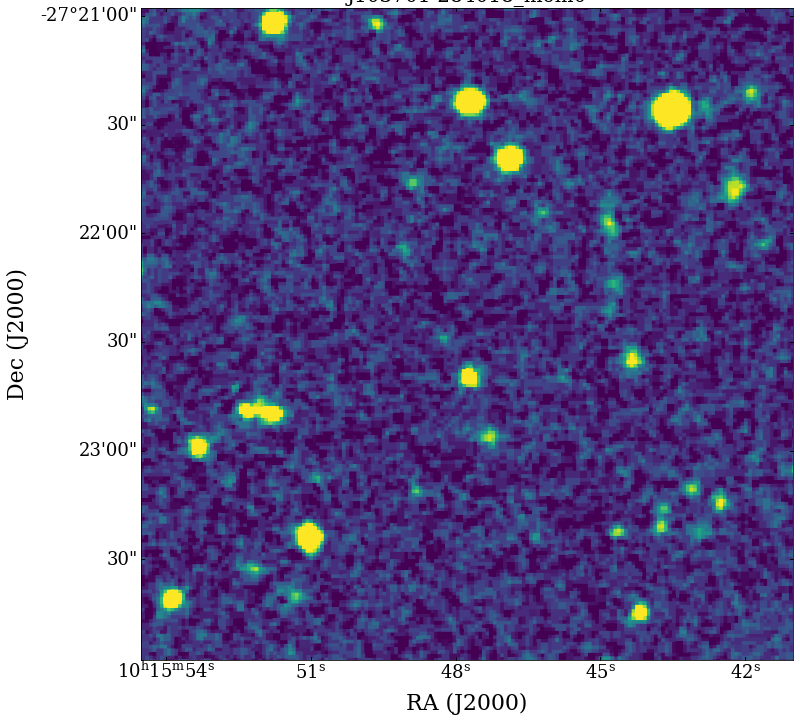

/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)


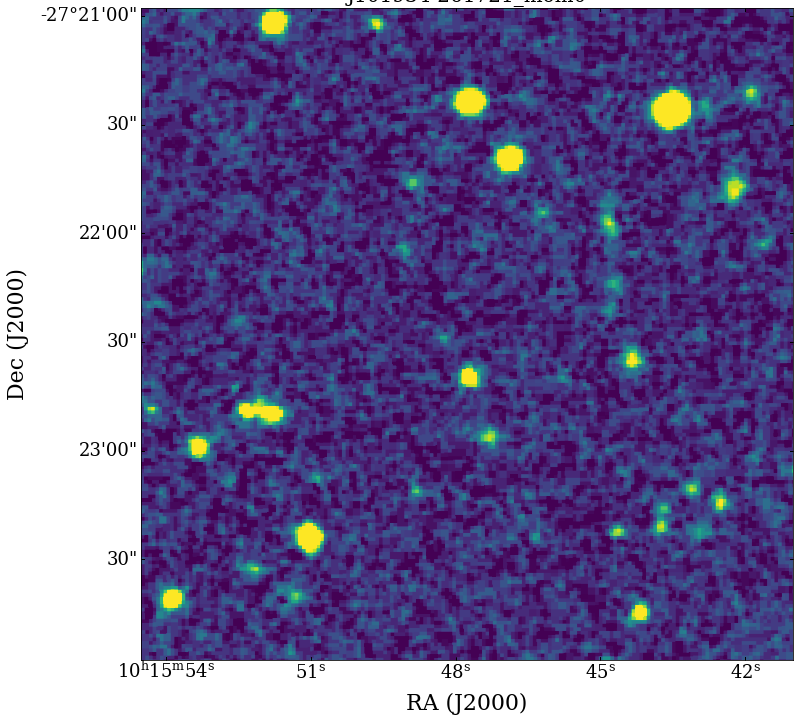

/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)


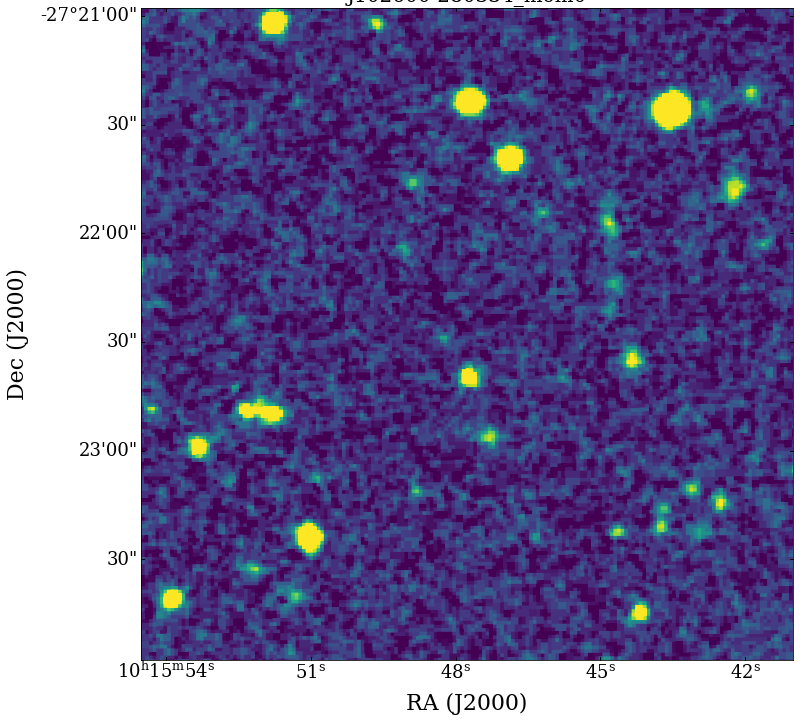

/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)


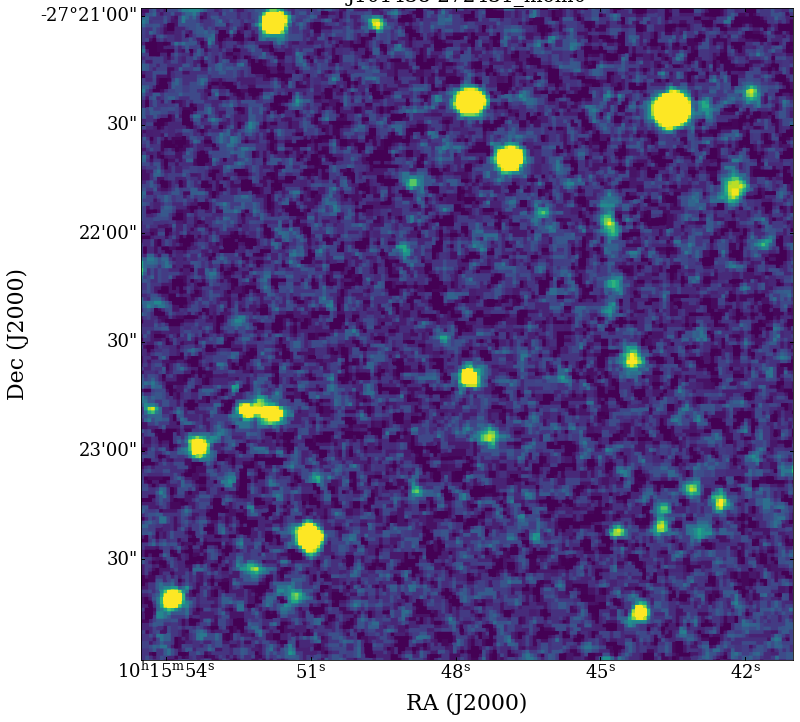

/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)


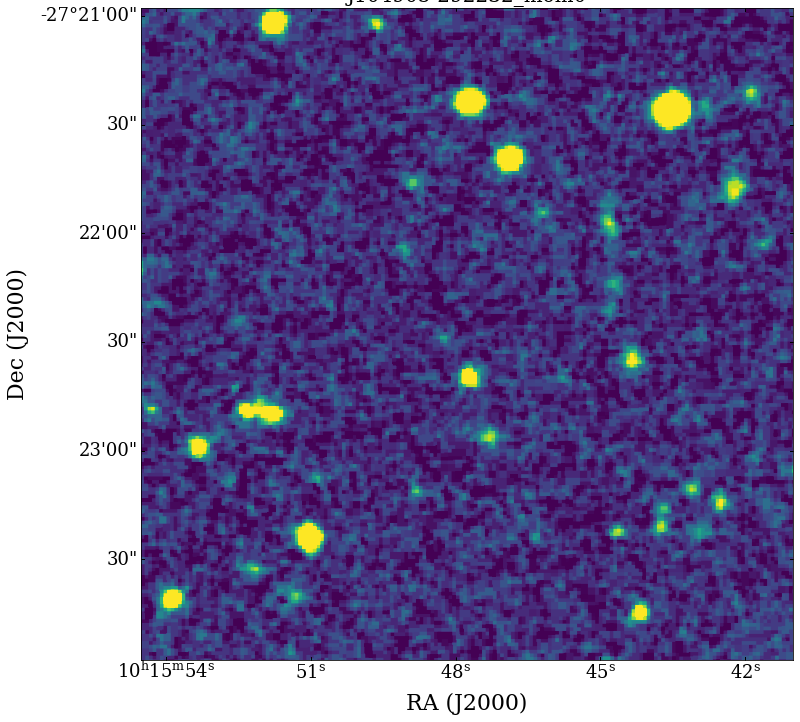

/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)


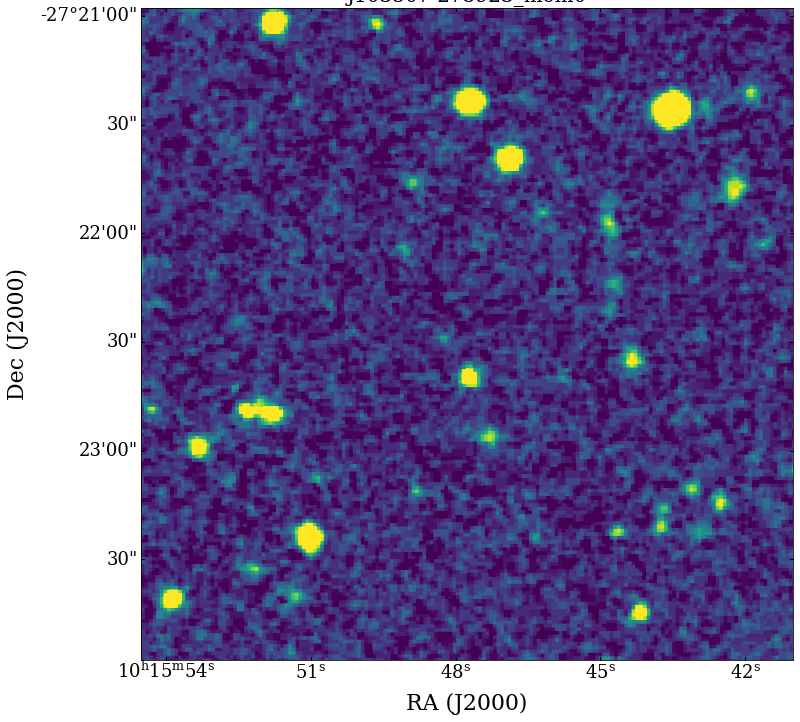

In [32]:
# read in HI data
# find optical image (DSS2 B)
# make the overlay
# note: sometimes there is no sufficently large (0.8 or 0.5 deg) optical image available, in this case the image is skipped


for hi_map in maps:
    hi_data = fits.open('/Users/denes/Research/WALLABY/Hydra_dr2/Hydra_dr2/WALLABY_PS_Hya_DR2_source_products/{}'.format(hi_map))  # Open the FITS file for reading
    d_hi = hi_data[0].data
    h_hi = hi_data[0].header
    #reprojected_cont, footprint = reproject_interp(cont_data, h_hi)
    rms = np.sqrt(np.mean(np.square(d_hi)))
    print(h_hi['CRVAL1'],h_hi['CRVAL2'], np.max(d_hi))

    #get optical image
    c = SkyCoord(h_hi['CRVAL1'], h_hi['CRVAL2'], unit="deg")
    print(c.ra, c.dec)
    path = SkyView.get_images(position='{} {}'.format(c.ra.to_string(sep=':'), c.dec.to_string(sep=':')), width=0.05*u.deg, height=0.05*u.deg, survey=['DSS2 Red'], pixels=[900,900])

    print(path)
    if len(path) !=0:

        hdulist_opt = path[0]
        d2 = hdulist_opt[0].data
        h2 = hdulist_opt[0].header

        #fig = plt.figure(figsize=(18, 12))
        #ax = fig.add_subplot(111)
        #im = ax.imshow(d2, cmap='Oranges')

        #reproject HI data

        hi_reprojected, footprint = reproject_interp(hi_data, h2)
        rms = np.sqrt(np.mean(np.square(hi_reprojected)))

        #plot data together

        fig = plt.figure(figsize=(12, 12))
        ax1 = fig.add_subplot(111, projection=WCS(hdulist_opt[0].header))
        ax1.imshow(d2, cmap='viridis', vmin=np.percentile(d2,10), vmax=np.percentile(d2,99))
        ax1.contour(hi_reprojected, cmap='Oranges', levels=[ rms, rms*2, rms*4, rms*6, rms*8])
        #ax1.contour(hi_reprojected, cmap='Oranges', levels=5)
        #levs = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])*10**22
        #ax1.contour(hi_reprojected, levels=0, cmap='Blues')
        #ax1.coords.grid(color='white')
        ax1.set_title('{}'.format(hi_map[8:-5]), fontsize=20)
        ax1.tick_params(axis='both', which='major', labelsize=18)
        ax1.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
        ax1.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

        fig.savefig('HI_continuum_overlays/{}_HI_map.png'.format(hi_map[8:-5]),dpi=200)
 


# use PANSTARRS images

In [41]:
%matplotlib inline
import numpy
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO
import pylab

In [42]:
def getimages(ra,dec,size=240,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

159.344167


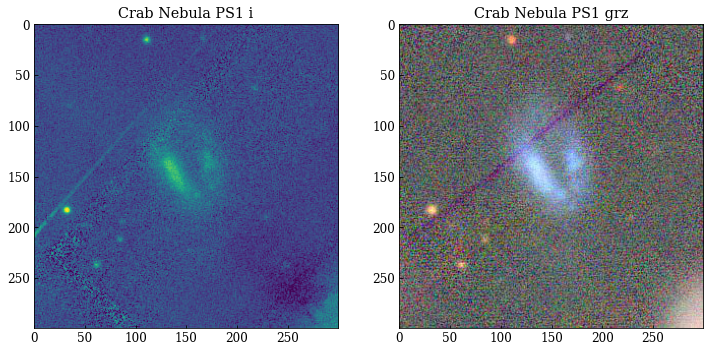

In [58]:
# Crab Nebula position
c = get_icrs_coordinates('PGC 753342')
print(c.ra.deg)

ra = 83.633210
dec = 22.014460
size = 300

# grayscale image
gim = getgrayim(c.ra.deg,c.dec.deg,size=size,filter="i")
# color image
cim = getcolorim(c.ra.deg,c.dec.deg,size=size,filters="grz")

pylab.rcParams.update({'font.size':12})
pylab.figure(1,(12,6))
pylab.subplot(121)
pylab.imshow(gim,origin="upper")
pylab.title('Crab Nebula PS1 i')
pylab.subplot(122)
pylab.title('Crab Nebula PS1 grz')
pylab.imshow(cim,origin="upper")

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)


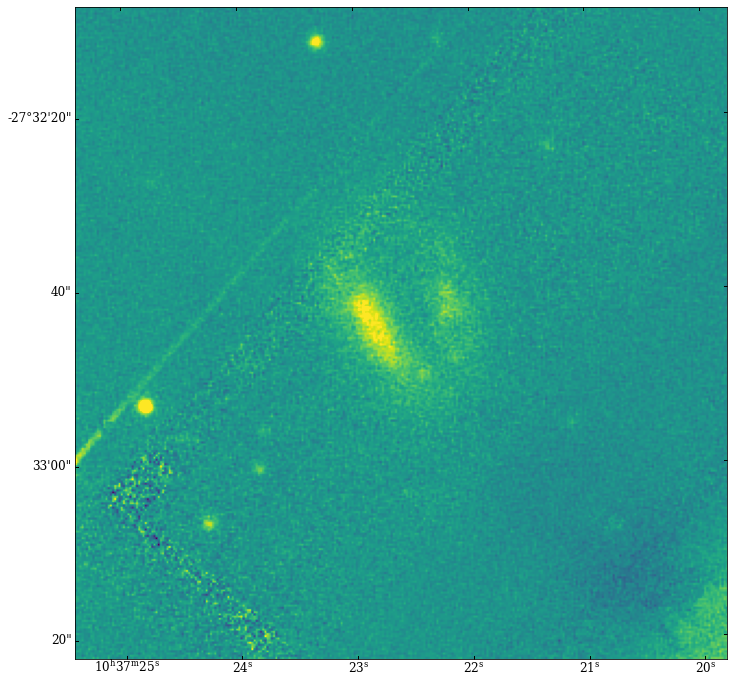

In [63]:
fitsurl = geturl(c.ra.deg,c.dec.deg, size=size, filters="i", format="fits")
fh = fits.open(fitsurl[0])
fim = fh[0].data
fh = fh[0].header

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(111, projection=WCS(fh))
ax1.imshow(fim, cmap='viridis', vmax=np.percentile(fim,99.9))

153.9493083333 -27.37438055556 1.0577055


Set OBSGEO-B to   -26.704100 from OBSGEO-[XYZ].
Set OBSGEO-H to      121.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and w

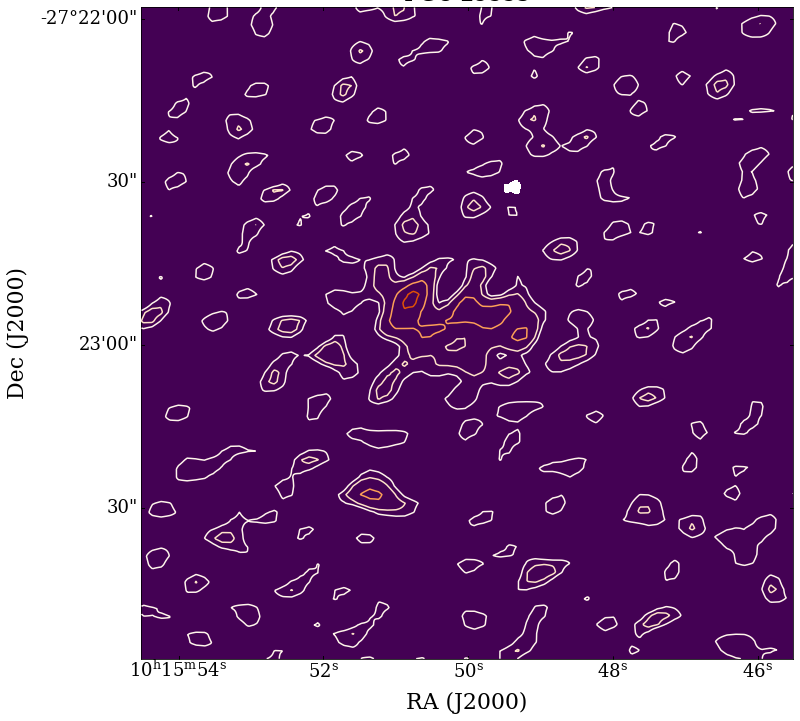

In [80]:
# read in HI data
# find optical image (DSS2 B)
# make the overlay
# note: sometimes there is no sufficently large (0.8 or 0.5 deg) optical image available, in this case the image is skipped

def make_overlay_v2(HI_image, name, size):
    hdulist_hi = fits.open('{}'.format(HI_image))
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header
    d = np.nan_to_num(d)
    rms = np.sqrt(np.mean(np.square(d)))
    print(h['CRVAL1'],h['CRVAL2'], np.max(d))

    #get optical image
    c = get_icrs_coordinates(name)
    #size = 300
    fitsurl = geturl(c.ra.deg,c.dec.deg, size=size, filters="i", format="fits")
    fh = fits.open(fitsurl[0])
    d2 = fh[0].data
    h2 = fh[0].header

    #reproject HI data

    hi_reprojected, footprint = reproject_interp(hdulist_hi, h2)
    rms = np.sqrt(np.mean(np.square(hi_reprojected)))

    #plot data together

    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(111, projection=WCS(hdulist_opt[0].header))
    ax1.imshow(d2, cmap='viridis', vmin=np.percentile(d2,10), vmax=np.percentile(d2,99.9))
    ax1.contour(hi_reprojected, cmap='Oranges', levels=[rms, rms*2, rms*4, rms*6, rms*8])
    #ax1.contour(hi_reprojected, cmap='Oranges', levels=5)
    #levs = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])*10**22
    #ax1.contour(hi_reprojected, levels=0, cmap='Blues')
    #ax1.coords.grid(color='white')
    ax1.set_title(name, fontsize=22)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax1.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

    fig.savefig('{}_overlay_continuum_v2.png'.format(name), dpi=100)

#make_overlay_v2('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 31440', 600)
#make_overlay_v2('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 31638', 600)
#make_overlay_v2('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 753342', 300)
make_overlay_v2('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 29553', 600)



153.949308333 -27.3743805556 2283.747
10h15m47.834s -27d22m27.77s


[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x176d79250>]]


/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releas

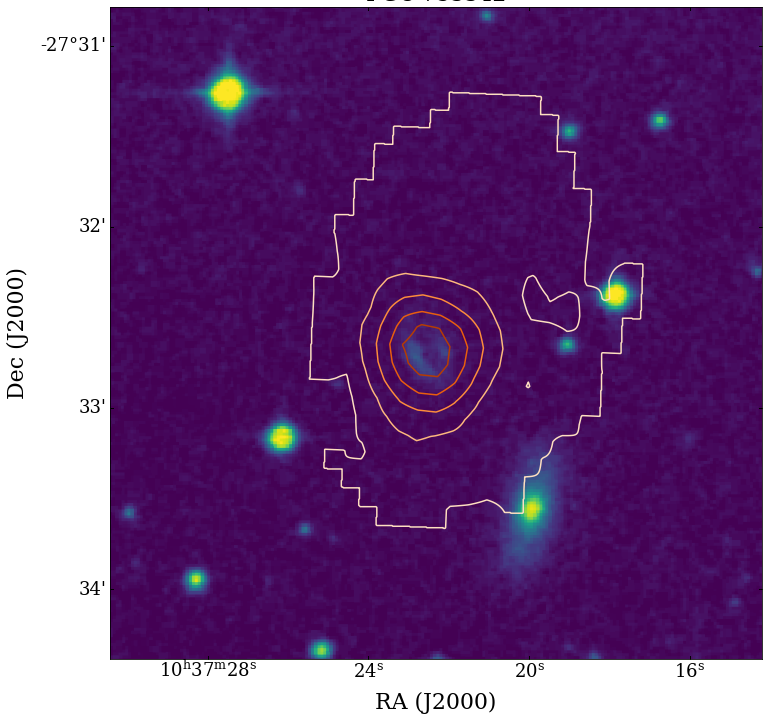

In [177]:
# read in HI data
# find optical image (DSS2 B)
# make the overlay
# note: sometimes there is no sufficently large (0.8 or 0.5 deg) optical image available, in this case the image is skipped

def make_overlay_v2(HI_image, name, size):
    hdulist_hi = fits.open('{}'.format(HI_image))
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header
    d = np.nan_to_num(d)
    rms = np.sqrt(np.mean(np.square(d)))
    print(h['CRVAL1'],h['CRVAL2'], np.max(d))

    #get optical image
    c = SkyCoord(h['CRVAL1'], h['CRVAL2'], unit="deg")
    print(c.ra.to_string(u.hour), c.dec)
    path = SkyView.get_images(position='10:37:22, -27:32:35', width=0.06*u.deg, height=0.06*u.deg, survey=['DSS2 Red'], pixels=[900,900])

    print(path)
    if len(path) !=0:

        hdulist_opt = path[0]
        d2 = hdulist_opt[0].data
        h2 = hdulist_opt[0].header

        #reproject HI data

        hi_reprojected, footprint = reproject_interp(hdulist_hi, h2)
        rms = np.sqrt(np.mean(np.square(hi_reprojected)))

        #plot data together

        fig = plt.figure(figsize=(12, 12))
        ax1 = fig.add_subplot(111, projection=WCS(hdulist_opt[0].header))
        ax1.imshow(d2, cmap='viridis', vmin=np.percentile(d2,10), vmax=np.percentile(d2,99.9))
        #ax1.imshow(d, cmap='viridis')
        #ax1.contour(d, cmap='Oranges', levels=5)
        ax1.contour(hi_reprojected, cmap='Oranges', levels=5)
        #levs = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])*10**22
        #ax1.contour(hi_reprojected, levels=0, cmap='Blues')
        #ax1.coords.grid(color='white')
        ax1.set_title(name, fontsize=22)
        ax1.tick_params(axis='both', which='major', labelsize=18)
        ax1.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
        ax1.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

        fig.savefig('{}_overlay_continuum_v4.png'.format(name), dpi=100)

#make_overlay_v2('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 31440', 600)
#make_overlay_v2('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 31638', 600)
#make_overlay_v2('/Users/denes/Research/High_lat_HI/ASKAP_data/continuum_data/Hydra_cont.fits', 'PGC 753342', 300)
make_overlay_v2('/Users/denes/Research/WALLABY/Hydra_dr2/Hydra_dr2/WALLABY_PS_Hya_DR2_source_products/WALLABY_J103722-273235_mom0.fits', 'PGC 753342', 0.1)



153.949308333 -27.3743805556 nan


/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releas

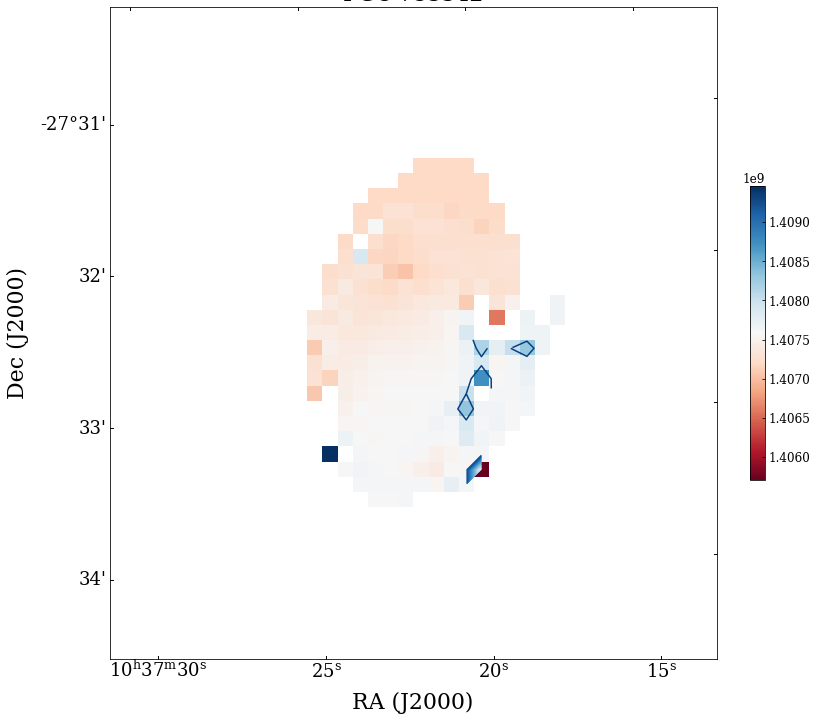

In [176]:
# plot moment 1 map

def plot_moment_1(HI_image, name, size):
    hdulist_hi = fits.open('{}'.format(HI_image))
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header
    #d = np.nan_to_num(d)
    rms = np.sqrt(np.mean(np.square(d)))
    print(h['CRVAL1'],h['CRVAL2'], np.max(d))

    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(111, projection=WCS(h))
    im = ax1.imshow(d, cmap='RdBu', vmin=1.4057e9)
    ax1.contour(d, cmap='Blues', levels=15)
    #levs = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])*10**22
    #ax1.contour(hi_reprojected, levels=0, cmap='Blues')
    #ax1.coords.grid(color='white')
    ax1.set_title(name, fontsize=22)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax1.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)
    cbar_hi = plt.colorbar(im, orientation='vertical', fraction=0.022, pad=0.05)

    fig.savefig('{}_mom1.png'.format(name), dpi=100)

plot_moment_1('/Users/denes/Research/WALLABY/Hydra_dr2/Hydra_dr2/WALLABY_PS_Hya_DR2_source_products/WALLABY_J103722-273235_mom1.fits', 'PGC 753342', 0.1)

